### Setup

In [6]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.human_behavioral_utils as human_behavioral_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import pickle

from models.value_models import ValueLinearModel, ValueMultilayerModel
from models.model_wrapper import ModelWrapper
from models.multinomial_logistic_regressor import MultinomialLogisticRegressor

from models.trainer import Trainer
from models.wcst_dataset import WcstDataset

import torch

import plotly.express as px

matplotlib.rcParams['figure.dpi'] = 150


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()

### Preprocess, generate feature selections, firing rates

In [4]:
subject = "sub-IR84"
session = "sess-1" # example session with spikes

formatted_beh = human_behavioral_utils.fetch_formatted_human_behavior(fs, subject, session)


In [5]:
print(f"{len(formatted_beh)} trials for decoding")

186 trials for decoding


In [6]:
spike_times = spike_general.get_spike_times(fs, "IR84", 1, species_dir="human-lfp")
# micro to milli
spike_times["SpikeTime"] = spike_times["SpikeTime"] / 1000

In [7]:
pre_interval = 800
post_interval = 1000
interval_size = 100
    
interval_size_secs = interval_size / 1000
intervals = behavioral_utils.get_trial_intervals(formatted_beh, "FeedbackOnset", pre_interval, post_interval)

In [8]:
spike_by_trial_interval = spike_utils.get_spikes_by_trial_interval(spike_times, intervals)
end_bin = (pre_interval + post_interval) / 1000 + interval_size_secs
firing_rates = spike_analysis.firing_rate(spike_by_trial_interval, spike_by_trial_interval, bins=np.arange(0, end_bin, interval_size_secs), smoothing=1)
print(f"Number of Units: {len(firing_rates.UnitID.unique())}")
unit_stats = spike_utils.get_stats_for_units(firing_rates)
spike_count_vars = unit_stats.SpikeCountVar
spike_count_vars = spike_count_vars[:, None]

spike_count_means = unit_stats.SpikeCountMean[:, None]

# valid_units = unit_stats[unit_stats.SpikeCountMean > 0.1].UnitID
valid_units = unit_stats.UnitID.unique()
print(f"Number of Units after filtering: {len(valid_units)}")

valid_firing_rates = firing_rates[firing_rates.UnitID.isin(valid_units)]

feature_selections = behavioral_utils.get_selection_features(formatted_beh)

Number of Units: 104
Number of Units after filtering: 104


/tmp/ipykernel_609414/3614175396.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  spike_count_vars = spike_count_vars[:, None]
/tmp/ipykernel_609414/3614175396.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  spike_count_means = unit_stats.SpikeCountMean[:, None]


In [18]:
firing_rates

,TrialNumber,UnitID,TimeBins,SpikeCounts,FiringRate
0,0,0,0.0,0.0,0.000000
1,0,0,0.1,0.0,0.000000
2,0,0,0.2,0.0,0.000000
3,0,0,0.3,0.0,0.000000
4,0,0,0.4,0.0,0.000000
...,...,...,...,...,...
348187,199,166,1.3,0.0,0.304826
348188,199,166,1.4,0.0,0.058691
348189,199,166,1.5,0.0,0.004566
348190,199,166,1.6,0.0,0.000134


### Feature Selection Decodability

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000

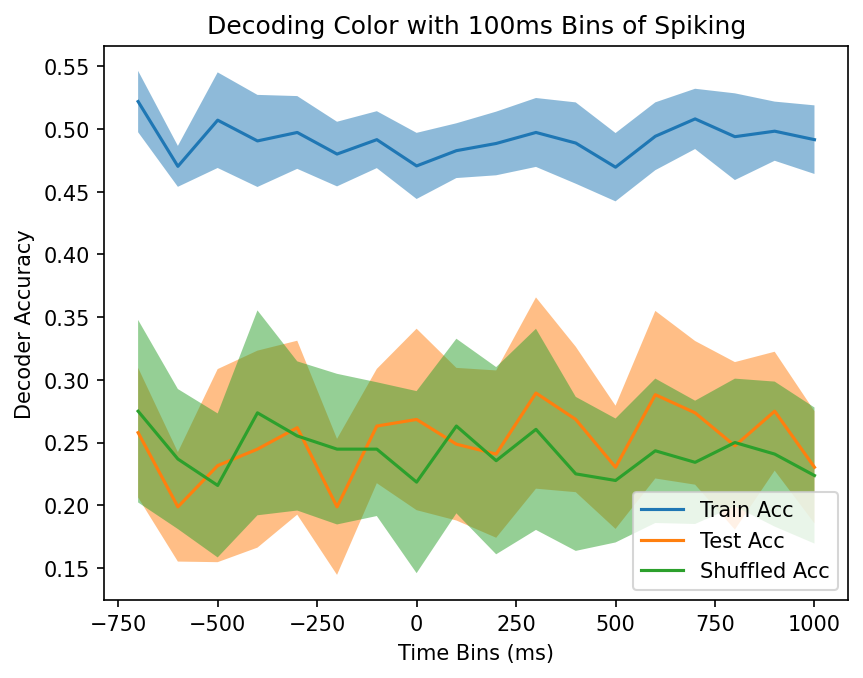

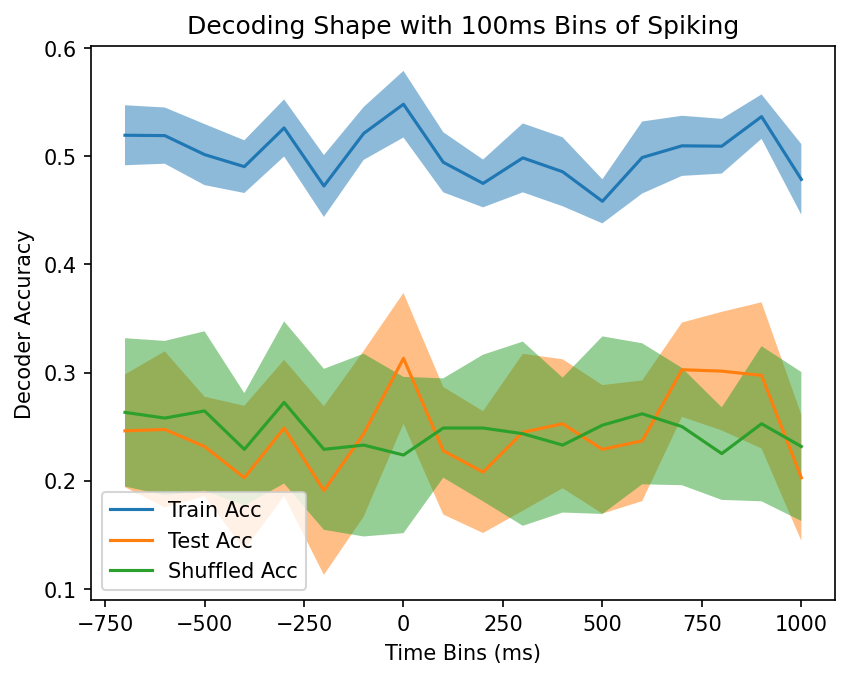

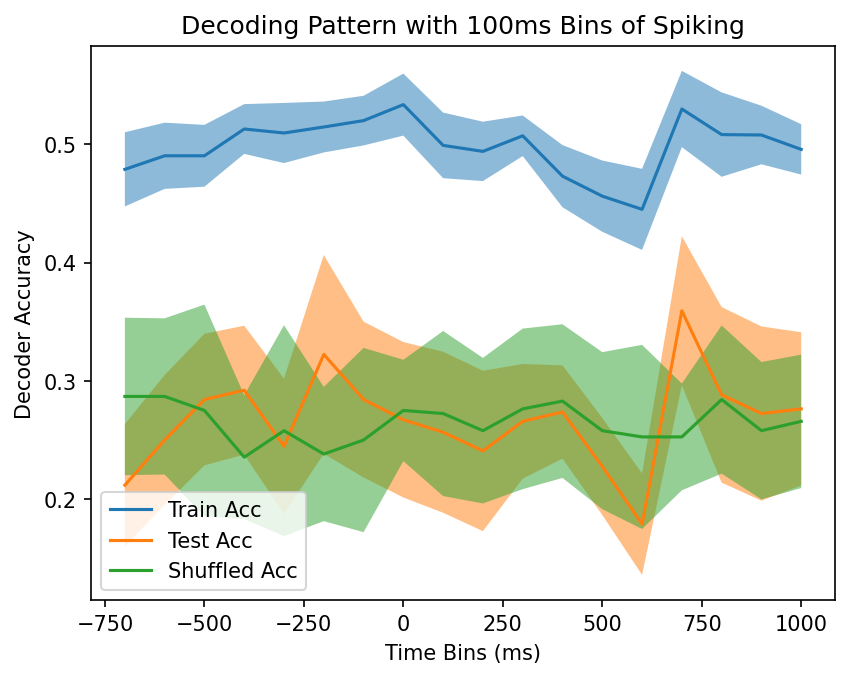

In [13]:
feature_dims = ["Color", "Shape", "Pattern"]
for feature_dim in feature_dims:
    num_neurons = len(valid_firing_rates.UnitID.unique())
    labels = feature_selections[feature_dim].unique()
    init_params = {"n_inputs": num_neurons, "n_classes": len(labels)}
    trainer = Trainer(learning_rate=0.01)
    wrapped = ModelWrapper(MultinomialLogisticRegressor, init_params, trainer, labels)

    mode = "SpikeCounts"

    # prep data for classification
    inputs = valid_firing_rates.rename(columns={mode: "Value"})
    labels = feature_selections.rename(columns={feature_dim: "Feature"})

    random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

    train_accs_by_bin, test_accs_by_bin, shuffled_accs, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
        wrapped, inputs, labels, np.arange(0, 1.8, 0.1), random_splitter
    )

    # generate figures
    fig, ax = plt.subplots()
    visualization_utils.visualize_accuracy_across_time_bins(
        train_accs_by_bin,
        pre_interval, post_interval, 100,
        ax,
        label="Train Acc",
        right_align=True
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        test_accs_by_bin,
        pre_interval, post_interval, 100,
        ax,
        label="Test Acc",
        right_align=True
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        shuffled_accs,
        pre_interval, post_interval, 100,
        ax,
        label="Shuffled Acc",
        right_align=True
    )
    ax.set_xlabel("Time Bins (ms)")
    ax.set_ylabel("Decoder Accuracy")
    ax.set_title(f"Decoding {feature_dim} with 100ms Bins of Spiking")
    ax.legend()

### Choice Decodability

In [9]:
print(formatted_beh.Item0Shape.unique())
print(formatted_beh.Item0Color.unique())
print(formatted_beh.Item0Pattern.unique())

['Q' 'C' 'T' 'S']
['M' 'Y' 'B' 'G']
['R' 'P' 'Z' 'L']


Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002


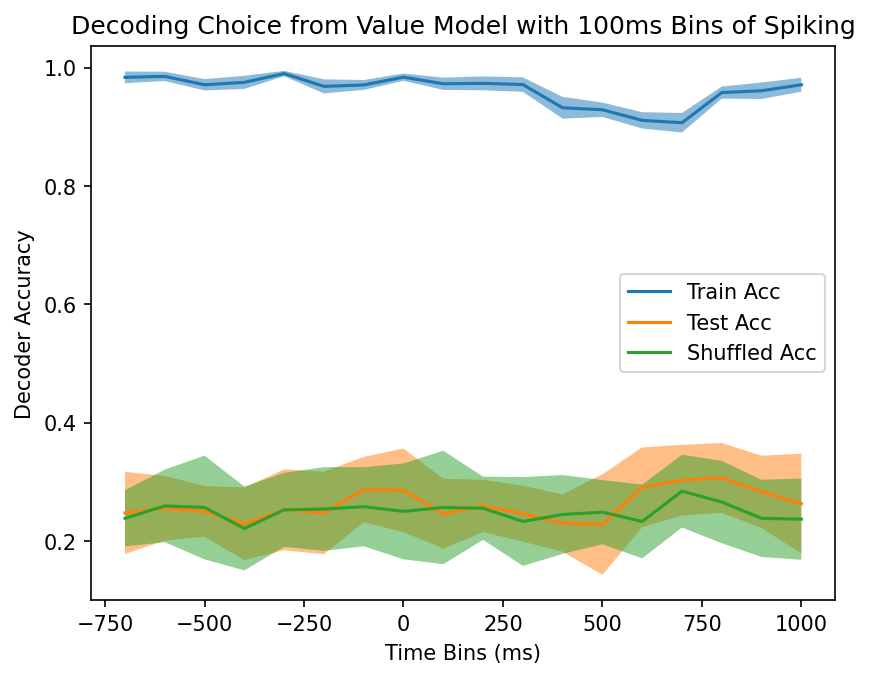

In [11]:
pre_interval = 800
post_interval = 1000

shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(formatted_beh)

num_neurons = len(valid_firing_rates.UnitID.unique())
labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "n_values": 12}
trainer = Trainer(learning_rate=0.1, max_iter=500)
wrapped = ModelWrapper(ValueLinearModel, init_params, trainer, labels)

mode = "SpikeCounts"

# prep data for classification
inputs = valid_firing_rates.rename(columns={mode: "Value"})
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

train_accs_by_bin, test_accs_by_bin, shuffled_accs, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 1.8, 0.1), random_splitter, cards=shuffled_card_idxs
)

# generate figures
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    train_accs_by_bin,
    pre_interval, post_interval, 100,
    ax,
    label="Train Acc",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_by_bin,
    pre_interval, post_interval, 100,
    ax,
    label="Test Acc",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    shuffled_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Shuffled Acc",
    right_align=True
)

ax.set_xlabel("Time Bins (ms)")
ax.set_ylabel("Decoder Accuracy")
ax.set_title(f"Decoding Choice from Value Model with 100ms Bins of Spiking")
ax.legend()

### Direction decodability

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002


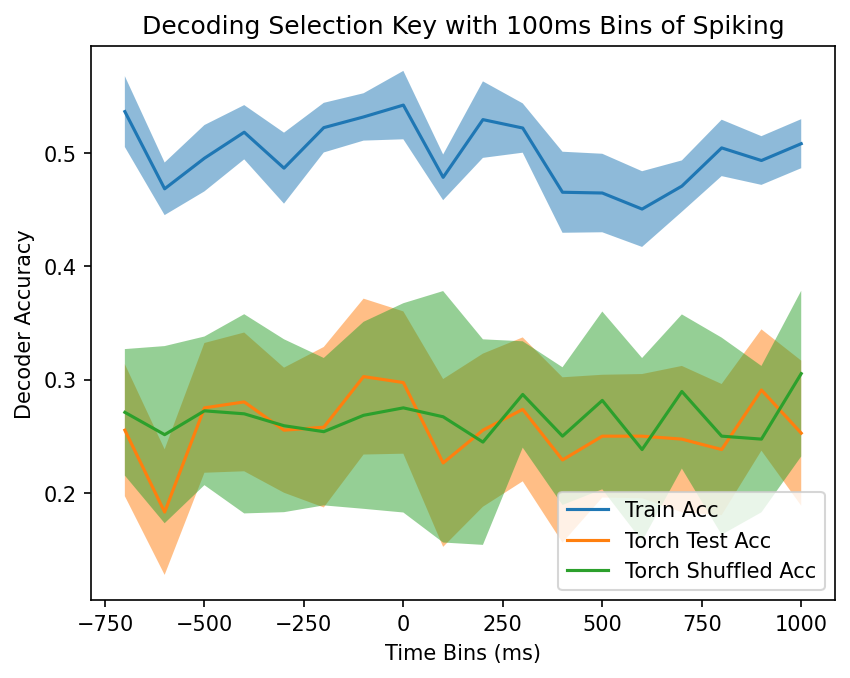

In [17]:
num_neurons = len(valid_firing_rates.UnitID.unique())
labels = formatted_beh.ItemChosen.unique()
init_params = {"n_inputs": num_neurons, "n_classes": len(labels)}
trainer = Trainer(learning_rate=0.01)
wrapped = ModelWrapper(MultinomialLogisticRegressor, init_params, trainer, labels)

mode = "SpikeCounts"

# prep data for classification
inputs = valid_firing_rates.rename(columns={mode: "Value"})
labels = formatted_beh.rename(columns={"ItemChosen": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

train_accs_by_bin, test_accs_by_bin, shuffled_accs, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 1.8, 0.1), random_splitter
)

# generate figures
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    train_accs_by_bin,
    pre_interval, post_interval, 100,
    ax,
    label="Train Acc",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_by_bin,
    pre_interval, post_interval, 100,
    ax,
    label="Torch Test Acc",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    shuffled_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Torch Shuffled Acc",
    right_align=True
)
ax.set_xlabel("Time Bins (ms)")
ax.set_ylabel("Decoder Accuracy")
ax.set_title(f"Decoding Selection Key with 100ms Bins of Spiking")
ax.legend()

### Analyze extent of overfitting by looking at test acc by epoch

In [ ]:
pre_interval = 1300
post_interval = 1500
device = "cuda" if torch.cuda.is_available() else "cpu"


num_neurons = len(firing_rates.UnitID.unique())
labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "n_values": 12}
trainer = Trainer(learning_rate=0.1, max_iter=5000)
model = ValueExpModel(**init_params)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
# just look at one time bin
# look at 0.6 because that should be where decodabilty is highest
inputs = inputs[np.isclose(inputs["TimeBins"], 0.6)]
# inputs = inputs[np.isclose(inputs["TimeBins"], 1.8)]

labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

x_train = classifier_utils.transform_to_input_data(inputs)
cards_train = classifier_utils.transform_cards_or_none(shuffled_card_idxs)
y_train = classifier_utils.transform_to_label_data(labels)

possible_labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
labels_to_idx = {label: idx for idx, label in enumerate(possible_labels)}
y_train_idxs = np.array([labels_to_idx[label] for label in y_train.tolist()]).astype(int)
dataset = WcstDataset(x_train, y_train_idxs, cards_train)
losses = trainer.train(model, dataset)

x = torch.Tensor(x_train).to(device)
cards = torch.Tensor(cards_train).to(torch.long).to(device)

probs = model(x, cards)
label_idxs = np.argmax(probs.detach().cpu().numpy(), axis=1)
train_acc = np.sum(label_idxs == y_train_idxs) / len(y_train_idxs)

print(train_acc)

fig, ax = plt.subplots()
ax.plot(losses)

### Maybe look at a non-linear model

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002


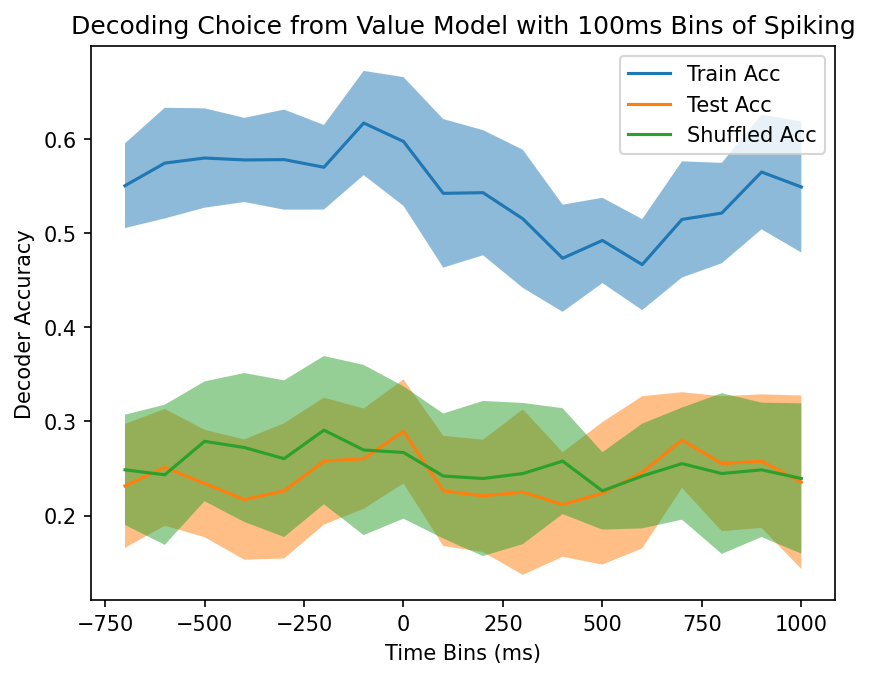

In [14]:
pre_interval = 800
post_interval = 1000

shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(formatted_beh)

num_neurons = len(valid_firing_rates.UnitID.unique())
labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "n_hidden": 12, "n_values": 12}
trainer = Trainer(learning_rate=0.1, max_iter=500, weight_decay=0.1)
wrapped = ModelWrapper(ValueMultilayerModel, init_params, trainer, labels)

mode = "SpikeCounts"

# prep data for classification
inputs = valid_firing_rates.rename(columns={mode: "Value"})
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

train_accs_by_bin, test_accs_by_bin, shuffled_accs, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 1.8, 0.1), random_splitter, cards=shuffled_card_idxs
)

# generate figures
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    train_accs_by_bin,
    pre_interval, post_interval, 100,
    ax,
    label="Train Acc",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_by_bin,
    pre_interval, post_interval, 100,
    ax,
    label="Test Acc",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    shuffled_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Shuffled Acc",
    right_align=True
)

ax.set_xlabel("Time Bins (ms)")
ax.set_ylabel("Decoder Accuracy")
ax.set_title(f"Decoding Choice from Value Model with 100ms Bins of Spiking")
ax.legend()